In [1]:
'''
    Implementation of Binary Classification Perceptron
    Author - Oyesh Mann Singh
    Date Completed - 10/22/2017
'''

import time
import numpy as np

import pandas as pd
from pandas import Series, DataFrame as df

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Since this is binary classification perceptron
# we are defining only two classes
classes = [1,6]

# Select images from each_each
each_class=500

# MnistDataset to load dataset
class MnistDataset(object):
    def __init__(self, csv_file, classes=classes, each_class=0, sort=False):
        df = pd.read_csv(csv_file)
        raw_data = df.loc[df['label'].isin(classes)]
        if each_class > 0 and sort:
            self.data = raw_data.groupby('label').head(each_class).sort_values(['label'])
        elif each_class > 0 and not sort:
            self.data = raw_data.groupby('label').head(each_class)
        else:
            self.data = raw_data
        self.label = self.data.iloc[:,0]
        self.image = self.data.iloc[:,1:]
        
    def __len__(self):
        return len(self.data)

# Perceptron class
class Perceptron(object):
    def __init__(self, classes=classes, lr=0.01, le=0.0, each_class=0, sort=False):
        self.lr = lr
        self.le = le
        
        train_dataset = MnistDataset('data/train.csv',classes=classes,each_class=each_class, sort=sort)
        test_dataset = MnistDataset('data/test.csv',classes=classes,each_class=each_class)
        
        # Convert dataframe to nd-array
        self.train_images = train_dataset.image.values
        self.train_labels = train_dataset.label.values
        self.train_labels = np.where(self.train_labels == classes[0], -1, 1)

        self.test_images = test_dataset.image.values
        self.test_labels = test_dataset.label.values
        self.test_labels = np.where(self.test_labels == classes[0], -1, 1)
        
        # Dimension of each image
        self.num_of_features = len(self.train_images[0])
        
        # Length of each dataset
        self.num_of_train_data = len(self.train_images)
        self.num_of_test_data = len(self.test_images)
        
        self.w_ = np.random.rand(1 + self.num_of_features)
        self.best_w_ = np.random.rand(1 + self.num_of_features)
        self.train_acc = []
        self.test_acc = []
        self.best_test_acc = 0
        self.score_list = np.zeros((len(self.test_labels),3))
        self.time_taken = 0.0
        self.best_iter = 0
        self.no_of_updates = 0
             
    # Calculate the dot product
    def dot_product(self, x):
        return np.dot(x, self.w_[1:]) + self.w_[0]
    
    # Predict the score
    def predict(self, x):
        return 1 if self.dot_product(x) >= 0.0 else -1
    
    # Test the model
    def test(self, itr):
        X_test = self.test_images
        y_test = self.test_labels
        test_acc_each = 0
        accuracy = 0
        for i in range(self.num_of_test_data):
            y_test_est = self.predict(X_test[i])
            if y_test_est == y_test[i]:
                test_acc_each += 1
                
        self.test_acc.append(test_acc_each)
        
        accuracy = (test_acc_each / self.num_of_test_data) * 100
        # If highest accuracy save the test_accuracy and the weights
        if(accuracy > self.best_test_acc):
            self.best_test_acc = accuracy
            self.best_w_ = self.w_
            self.best_iter = itr
            
            
    # Calculate the dot product using best weights
    def best_dot_product(self, x):
        return np.dot(x, self.best_w_[1:]) + self.best_w_[0]
            
        
    # Calculate the best score using best weights
    def best_test(self):
        X_images = self.test_images
        y_labels = self.test_labels
        for i in range(self.num_of_test_data):
            y_score = self.best_dot_product(X_images[i])
            self.score_list[i] =  y_score, i, y_labels[i]
        return self.score_list

    
    # Train the model
    def train(self):
        X=self.train_images
        y=self.train_labels
        
        # If error is introduced
        if(self.le > 0.0):
            rand_index = np.random.randint(1, self.num_of_train_data, size=int(self.le * self.num_of_train_data))
            for i in rand_index:
                if(y[i] == 1):
                    y[i] = -1
                elif (y[i] == -1):
                    y[i] = 1
        
        start_time = time.time()
        for i in range(self.num_of_train_data):
            accuracy = 0
            acc_each=0
            y_est = self.predict(X[i])
            if y_est == y[i]:
                acc_each += 1
            else:
                self.w_[1:] += self.lr * (y[i] - y_est) * X[i]
                self.w_[0] +=  self.lr * (y[i] - y_est)
                self.no_of_updates += 1
            self.train_acc.append(acc_each)
  
            Perceptron.test(self, i)
        self.time_taken = time.time() - start_time
        
        return self
    
    
    # Visualize the best and worst from each class
    def visualize(self):
        df = pd.DataFrame(self.score_list,columns=['score','image_number','labels'])
        
        # Sort the calculated score_list based on grouped labels
        sort_data = df.groupby('labels').head(1000).sort_values(['labels'])

        # Separate the data into two dataframe baesd on class label
        # Sort this data simultaneoulsy in ascending order based on score
        only_label_1 = sort_data[0:500].sort_values(['score'])
        only_label_6 = sort_data[501:].sort_values(['score'])

        # Worst and Best have lower and higher scores respectively
        # So, select 20 worst and best from each class
        best_images_label_1 = only_label_1[0:20]['image_number'].values.astype(int)
        worst_images_label_1 = only_label_1[480:500]['image_number'].values.astype(int)

        worst_images_label_6 = only_label_6[0:20]['image_number'].values.astype(int)
        best_images_label_6 = only_label_6[480:500]['image_number'].values.astype(int)
        
        # Enlist the worst and best image number into list
        # So that its easier in looping
        best_worst_list = []
        best_worst_list.append(worst_images_label_1)
        best_worst_list.append(best_images_label_1)
        best_worst_list.append(worst_images_label_6)
        best_worst_list.append(best_images_label_6)
        
        # Figure title
        fig_title = ['Worst_Images_Class_1','Best_Images_Class_1','Worst_Images_Class_6','Best_Images_Class_6']
        count = 0
        for each in best_worst_list:
            w=10
            h=10
            fig=plt.figure(figsize=(8, 8))
            fig.suptitle(fig_title[count])
            columns = 4
            rows = 5
            for i, j in enumerate(each):
                # select the corresponding image from testing pool and reshape
                img = self.test_images[j].reshape(28,28)
                fig.add_subplot(rows, columns, i+1)
                plt.imshow(img)
            plt.savefig(fig_title[count]) 
            count += 1
        plt.show()

In [2]:
# Universal perceptron function
def normal_perceptron(classes=classes, each_class=each_class,le=0.0,sort=False,visualize=False,fig_title=''):
    percept = Perceptron(classes=classes, each_class=each_class, le=le,sort=sort)
    train_perceptron = percept.train()
    print('Time taken for training/testing = {0}'.format(percept.time_taken))
    print('Best accuracy = {0}% occurs at {1}th iteration'.format(percept.best_test_acc, percept.best_iter))
    print('No of updates made = {0}'.format(percept.no_of_updates))
    
    plt.plot(range(percept.num_of_test_data), percept.test_acc)
    plt.title(fig_title)
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.tight_layout()
    plt.savefig(fig_title) 
    plt.show()
    
    if(visualize):
        score_list = percept.best_test()
        percept.visualize()

    return train_perceptron

Time taken for training/testing = 13.232141256332397
Best accuracy = 99.2% occurs at 501th iteration
No of updates made = 22


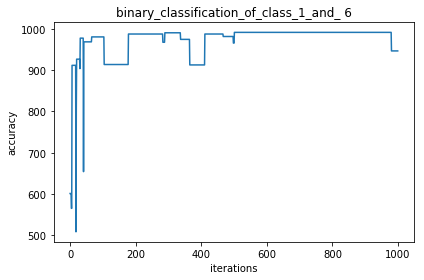

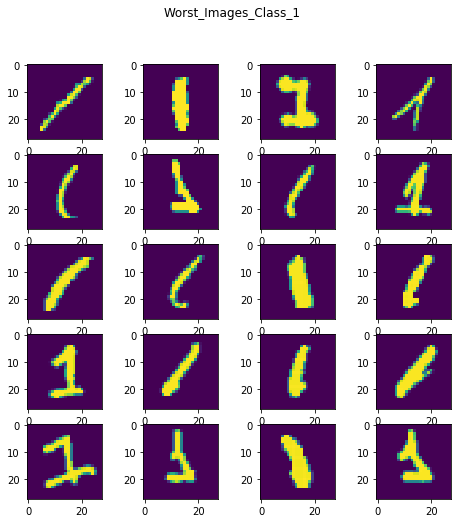

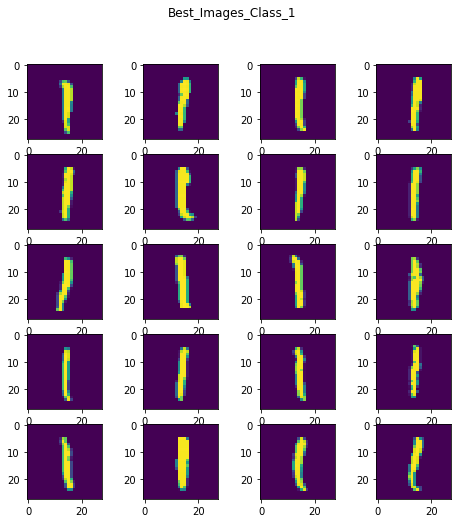

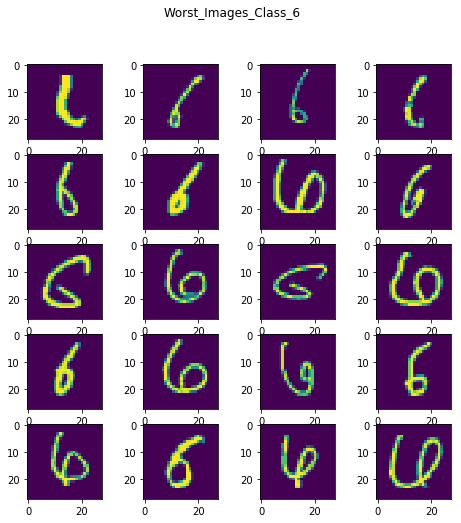

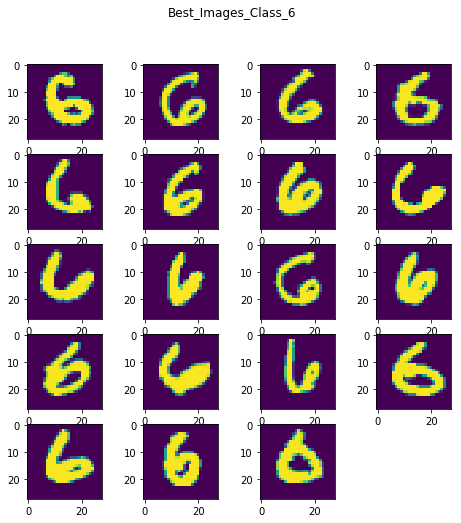

In [3]:
normal_percept = normal_perceptron(visualize=True,fig_title='binary_classification_of_class_1_and_ 6')

In [5]:
# Question d means to visualize the decision boundary of weight vector
def visualize_weights(weight=None,pos_fig_title='',neg_fig_title=''):
    weight_vector = np.delete(weight.w_,0)

    positive_weight = np.zeros(weight_vector.size)
    negative_weight = np.zeros(weight_vector.size)

    for i in range(len(weight_vector)):
        if weight_vector[i] > 0:
            positive_weight[i] = weight_vector[i]
            negative_weight[i] = 0
        else:
            positive_weight[i] = 0
            negative_weight[i] = weight_vector[i]

    new_pos_vector = positive_weight.reshape(28,28)
    new_neg_vector = negative_weight.reshape(28,28)

    plt.figure()
    plt.title(pos_fig_title)
    plt.imshow(new_pos_vector,cmap='gray')
    plt.savefig(pos_fig_title)

    plt.figure()
    plt.title(neg_fig_title)
    plt.imshow(new_neg_vector,cmap='gray')
    plt.savefig(neg_fig_title)

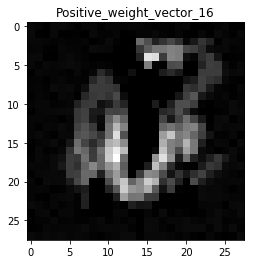

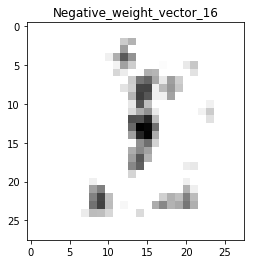

In [5]:
visualize_weights(normal_percept,pos_fig_title='Positive_weight_vector_16',neg_fig_title='Negative_weight_vector_16')

Time taken for training/testing = 13.492166757583618
Best accuracy = 99.1% occurs at 620th iteration
No of updates made = 168


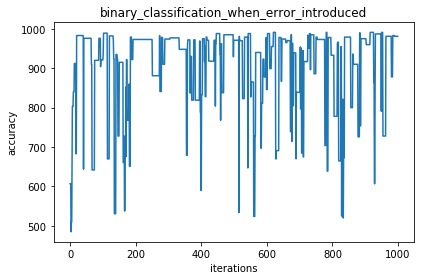

In [6]:
error_result = normal_perceptron(le=0.1,each_class=each_class,fig_title='binary_classification_when_error_introduced')

Time taken for training/testing = 13.623361825942993
Best accuracy = 59.0% occurs at 0th iteration
No of updates made = 3


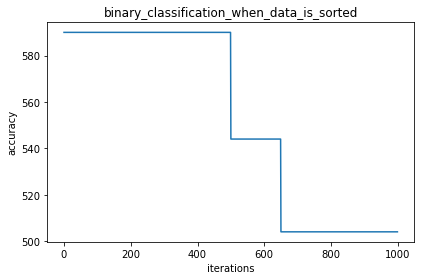

In [7]:
sorted_train_result = normal_perceptron(sort=True,fig_title='binary_classification_when_data_is_sorted')

Time taken for training/testing = 12.775367259979248
Best accuracy = 94.39999999999999% occurs at 310th iteration
No of updates made = 69


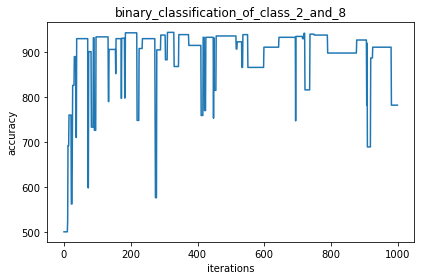

In [3]:
normal_perceptron_28 = normal_perceptron(classes=[2,8],fig_title='binary_classification_of_class_2_and_8')

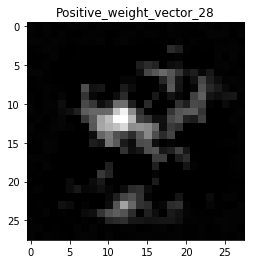

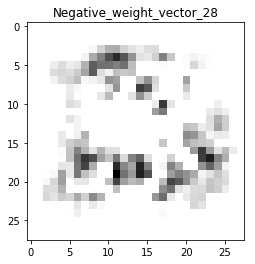

In [6]:
visualize_weights(normal_perceptron_28,pos_fig_title='Positive_weight_vector_28',neg_fig_title='Negative_weight_vector_28')

Time taken for training/testing = 0.0008149147033691406
Best accuracy = 80.0% occurs at 6th iteration
No of updates made = 3


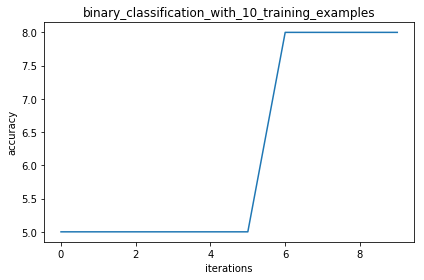

In [7]:
question_i_1 = normal_perceptron(each_class=5,fig_title='binary_classification_with_10_training_examples')

Time taken for training/testing = 12.530592441558838
Best accuracy = 99.1% occurs at 501th iteration
No of updates made = 22


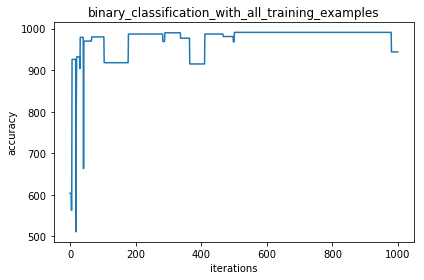

In [8]:
question_i_2 = normal_perceptron(fig_title='binary_classification_with_all_training_examples')